<a href="https://colab.research.google.com/github/mwithgod3952/Machine_Learning_Theory_jh/blob/master/Implementation_of_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***References***

    - 참조논문 : Implementation of Kalman Filter, Mohamed LAARAIEDH
    - 참조논문 : An Introduction to the Kalman Filter by Greg Welch1 and Gary Bishop2
    - 참고자료 : Understanding Kalman Filters with Python

***https://medium.com/@jaems33/understanding-kalman-filters-with-python-2310e87b8f48***

***Preview_1)***    

    - 가중합 
        : 내적을 이용한 가중합 

***Example***

In [ ]:
import numpy as np
a = np.array([0.5, 0.3, 0.1, 0.08, 0.02])
b = np.arange(15).reshape(5, 3)
print('First array', a)
print('Second array including 5 arrays')
b

First array [0.5  0.3  0.1  0.08 0.02]
Second array including 5 arrays


array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14]])

    1) 0.5*0 + 0.3*3 + 0.1*6 + 0.08*9 + 0.02*12  = 2.46
    2) 0.5*1 + 0.3*4 + 0.1*7 + 0.08*10 + 0.02*13 = 3.46
    3) 0.5*2 + 0.3*5 + 0.1*8 + 0.08*11 + 0.02*14 = 4.46

In [ ]:
Weight_sum = np.dot(a ,b)
print('Weight_sum' , Weight_sum)

Weight_sum [2.46 3.46 4.46]


#### ***Kalman Filter_Ver_1***

##### ***1) Prediction step***

    - X : The mean state estimate of the previous step(k - 1)
    - A : The transition n * n matrix.
        * dot(A, X)
            : 이전 단계에서의 평상태 추정
            : n * n 전이행렬 양간의 가중합

    - B : The input effect matrix
    - U : The control input  

            : 실제값 또는 De-noising이 필요한, Error 또는 Noise 값을 내포한 일련의 관측-시퀀스에 대하여, Position 및 Velocity 정보에 대한, 정확도 및 연속적인 수정 정보를 담은 행렬
            : 시간변화에 따라 관측되는 특정 Noise-effect를 제거하는 과정에서,  타켓벨류의 다이나믹이 감쇠 및 예측되어 결정

    - P : The state covariance of previous step (k−1)
    - Q : The process noise covariance matrix

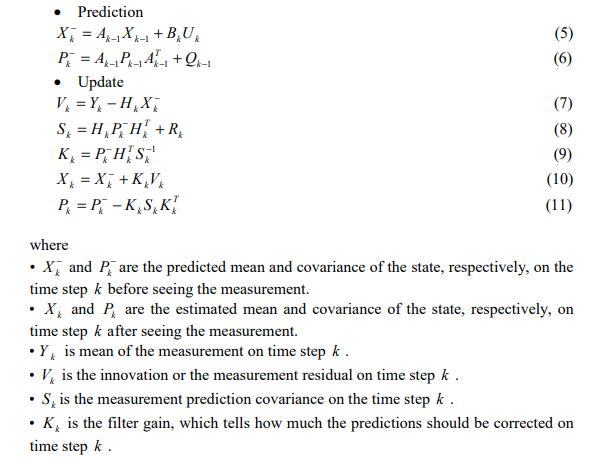

In [ ]:
Image(filename="drive/MyDrive/image/prediction_update_state.png")

    - X는 이전 시점의 값과 비교하여 반복적인 평균 예측을 이루어 감 (5)
    - 동일한 전이행렬을 활용하여 공분산 역시 반복적인 예측을 이루어 감 단, 이 때 Noise에 대한 분산을 함께 고려 (6)

    - 결과적으로는 평균과 분산을 예측

In [ ]:
from numpy import dot
def kf_predict(X, P, A, Q, B, U):
    X = dot(A, X) + dot(B, U)
    P = dot(A, dot(P, A.T)) + Q
    return(X, P) 

##### ***2) Update step***

    - 시간 k에 대하여, Update stepd은 다음 X와 다음 P(특정 특정 분산의 공분산)을 계산하고,
    - system state의 P는 새로운 Y값을 예측함에 따라 구해진다. 
    - 값은 지속적으로 Update 됨으로, H와 R 각각 측정행렬 및 측정 공분산행렬을 마련하여 값을 할당한다.

    IM : the Mean of predictive distribution of Y
    IS : the Covariance or predictive mean of Y
     K : the Kalman Gain matrix
    LH : the Predictive probability (likelihood) of measurement which is computed using the Python function gauss_pdf. 


In [ ]:
from numpy import dot, sum, tile, linalg
from numpy.linalg import inv

In [1]:
def kf_update(X, P, Y, H, R):
    IM = dot(H, X)                           # IM : Y의 분포에 따른 평균예측                 
    IS = R + dot(H, dot(P, H.T))             # IS : Y의 평균에 따른 공분산 예측
    K = dot(P, dot(H.T, inv(IS)))
    X = X + dot(K, (Y-IM))
    P = P - dot(K, dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)                # LH : Gaussian Distribution PDF(정규분포)를 통한 '가능도' 계산 즉, 연속사건에 대한 PDF값 추정
    return (X,P,K,IM,IS,LH)

def gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - tile(M, X.shape[1])
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(np.linalg.det(S))
        P = exp(-E)
    elif X.shape[1] == 1:
         DX = tile(X, M.shape[1])- M
         E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0)
         E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(np.linalg.det(S))
         P = exp(-E)
    else:
        DX = X-M
        E = 0.5 * dot(DX.T, dot(inv(S), DX))
        E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(np.linalg.det(S))
        P = exp(-E)
    return (P[0],E[0]) 

In [ ]:
from numpy import *
from numpy.linalg import inv

dt = 0.1

X = array([[0.0], [0.0], [0.1], [0.1]])
P = diag((0.01, 0.01, 0.01, 0.01))
A = array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0,1]])
Q = eye(X.shape[0])
B = eye(X.shape[0])
U = zeros((X.shape[0],1)) 
Y = array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = eye(Y.shape[0])
N_iter = 50

for i in arange(0, N_iter):
    (X, P) = kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]]) 

In [ ]:
Y

array([[3.44827942],
       [3.78742439]])

#### ***Kalman Filter_Ver_2***